# Feature Engineering
Carefully teasing out patterns in the corpus is a key part of natural language processing. Cleaning is all done, so now it's time to get things that a human speaker would know out of the data. The result of this notebook is a large csv. From here, the data goes into two paths: the unsupervised path and the supervised path.

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run ../scripts/post_scraping_text_processing.py functions

Text processing functions loaded.


In [3]:
df = pd.read_csv("../assets/data/assembled_20180716.csv", index_col=0)

In [4]:
df.columns

Index(['artist', 'album', 'text', 'release', 'name', 'year',
       'written_before_2002', 'written_before_2004', 'written_before_2006',
       'written_before_2008', 'written_after_2016'],
      dtype='object')

In [5]:
df.shape

(15385, 11)

In [6]:
df.loc[52145,'text'].lower()

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

## Vocables: Non-lexical words
Turkish songs use certain sounds that don't carry strict lexical meaning, but are expressions of grief or are just good musical material. We should include some scripting to figure out if there's any pattern in the use of these vocables. I've picked 5 common vocables: `oy`, `ah`, `ey`, `vay`, and `oh`. For each, I'm making a column for the total amount of characters that each song spends on these vocables as well as replacing them in the corpus.

In [7]:
# First the vocable patterns: each vocable can have 1+ of all the characters in it
vocable_patterns = {
    'oy':  r'\bo+y+\b',
    'ah':  r'\ba+h+\b',
    'ey':  r'\be+y+\b',
    'vay': r'\bva+y+\b',
    'oh':  r'\bo+h+\b',
}

In [8]:
def vocable_counter(text, vocable_pattern = r'\bo+h+\b'):
    list_of_vocables = re.findall(vocable_pattern, text.lower())
    if list_of_vocables != None:
        len_voc = 0
        for match in list_of_vocables:
            len_voc += len(match)
        return len_voc
    else:
        return 0
    
def vocable_encoder(text, vocable_pattern = r'\bo+h+\b'):
    text = text.lower()
    list_of_vocables = re.findall(vocable_pattern, text)
    if list_of_vocables != None:
        for match in list_of_vocables:
            text = re.sub(match, key, text)
        return text
    else:
        return text

In [9]:
test = 'Ellemeyin beni bu gece dostlar Çok büyük derdim var İçimdeki boşluk içkiyle doldu Benim kendime kastım var Dönse de dünya artık çevremde Durmuyor ruhum bu süslü bedende Ve yine o şişe yine elimde Tükensin artık Ellemeyin beni ah bu zamanlar Çok büyük derdim var İçimdeki boşluk içkiyle doldu Benim kendime kastım var'

In [10]:
vocable_counter(test, r'\bo+h+\b')

0

In [11]:
vocable_encoder(test, r'\bo+h+\b')

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

In [12]:
# Next the counter. For each key in the dictionary above this loop makes a new column.
for key, value in vocable_patterns.items():
    def vocable_counter(text, vocable_pattern = value):
        list_of_vocables = re.findall(vocable_pattern, text.lower())
        if list_of_vocables != None:
            len_voc = 0
            for match in list_of_vocables:
                len_voc += len(match)
            return len_voc
        else:
            return 0
    df[key+'_length'] = df['text'].map(vocable_counter)

In [13]:
# Finally, a loop to replace all the long drawn out vocables with a simple short version

for key, value in vocable_patterns.items():
    def vocable_encoder(text, vocable_pattern = value):
        text = text.lower()
        list_of_vocables = list(re.findall(vocable_pattern, text))
        if list_of_vocables != None:
            for match in list_of_vocables:
                text = re.sub(match, key, text)
        return text
    df['text'] = df['text'].map(vocable_encoder)

In [14]:
df.loc[52145,'text']

'ellemeyin beni bu gece dostlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var dönse de dünya artık çevremde durmuyor ruhum bu süslü bedende ve yine o şişe yine elimde tükensin artık ellemeyin beni ah bu zamanlar çok büyük derdim var i̇çimdeki boşluk içkiyle doldu benim kendime kastım var'

In [15]:
df['text'] = df['text'].map(lambda x: re.sub('i̇', 'i', x))

In [16]:
df.loc[38252,'text']

'insanlar kendini bilebilseydi dünyada haksızlık kavga olmazdı insan doğan yine insan ölseydi belki de dünyada hayvan kalmazdı hayvanlar yabanda sürüsüyünen geçinemez biri birisiyen insan cennetinin hurisiyinen sevişseydi hak yabana salmazdı tüm canların hak olduğun bilmese hakkın aşkı yüreğine dolmasa o güzel cemale aşık olmasa kul garibim bu sazını çalmazdı söz&müzik neşet ertaş'

## Some other simple features
- longest word
- total words
- how many words are repeated
- how many bigrams are repeated
- most common bigram

***Longest word turns out to be a hugely important feature. I believe this might be for one or both of the following reasons:    
1) It reflects linguistic data that lemmatization cuts off  
2) Newer songs are more sloppily transcribed, and I wasn't able to scrape this away entirely***

In [17]:
def find_longest_word(text):
    """Finds the longest word in a lyric"""
    r = 0
    for i in text.split():
        if len(i) > r:
            r = len(i)
    return r

In [18]:
df['longest_word_length'] = df['text'].map(find_longest_word)

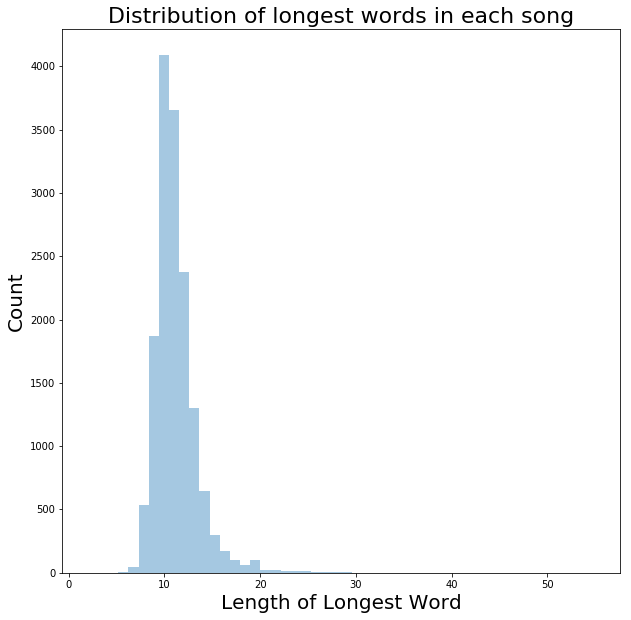

In [19]:
plt.figure(figsize = (10,10))
sns.distplot(df['longest_word_length'], kde = False)
plt.title("Distribution of longest words in each song", fontsize = 22)
plt.xlabel("Length of Longest Word", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.savefig("../assets/visualizations/longest_word_distribution.png")

In [20]:
print(df[df['longest_word_length'] > 40].loc[21125,'written_before_2002'])
df[df['longest_word_length'] > 40].loc[21125,'text']

1


'dün yine seni andik cümbür cemaat cümbür andik ayazda kaldik cümbür cemaat cümbür kahkaha attik durduk her yerde seni sorduk sordukça hasta olduk cümbür cemaat cümbür cümbürücümcümbürübürücümbürcümbürcemaatcümbür siseler elimizde cümbür cemaat cümbür leblebi cebimizde cümbür cemaat cümbür hasret var içimizde sen yoksun aramizda süphe var kafamizda cümbür cemaat cümbür cümbürücümcümbürübürücümbürcümbürcemaatcümbür gel artik bekiyoruz cümbür cemaat cümbür seni sayikliyoruz cümbür cemaat cümbür hiç mutlu olmuyoruz meskten zevk almiyoruz hep seni ariyoruz cümbür cemaat cümbür cümbürücümcümbürübürücümbürcümbürcemaatcümbür'

In [21]:
df['total_words'] = df['text'].map(lambda x: len(x.split()))

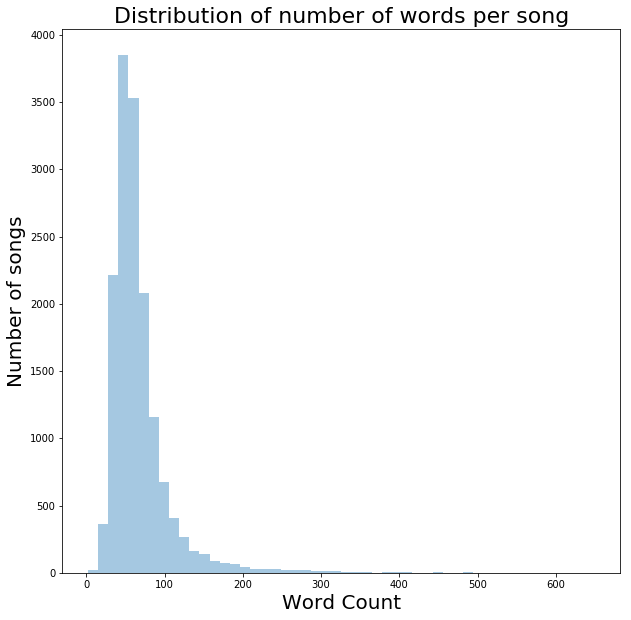

In [22]:
plt.figure(figsize = (10,10))
sns.distplot(df['total_words'], kde = False)
plt.title("Distribution of number of words per song", fontsize = 22)
plt.xlabel("Word Count", fontsize = 20)
plt.ylabel("Number of songs", fontsize = 20)
plt.savefig("../assets/visualizations/number_of_word_distribution.png")

In [23]:
print(df[df['total_words'] > 40].loc[21125,'written_before_2002'])
df[df['total_words'] == df['total_words'].max()].loc[45424, 'text']

1


'ais ezhel ve yine bizle sekizle çekil ve rap izle delirmemen işte değil hemen iste dumanını al buna kulağını aç aga bu takımla kazanılan bu kaçıncı maç hacı kötü rapin tekler senin rapim teklen benim sende tek dert kesin neden taglenmediğin gelir tekmem çetin gider eklem yerin bana back ver kariyerim beklenmedik ve hala türkçe rapte zihniyet eksik arabesk yapar adam ismide rapçi fanın olması için iş ve gerekli de nasıl rap yapak aga kişneyerek mi ve de rapi batağından aldık yaparız adam kızmamalısın bize rapi çakarız apansız aramızda kalsın kafanız kadardır aga zıpla lan çık o yatağımdan artık red bize  gibi orjinal halk akımları gerek yapamıyo yer altının paf takımları rapi yolda bollamayla rahat takılmanın bize benzetilmen sağlıyorsa altyapı hazır demek fark atıp açtık iyice arayı siz de hala hayallerde hasmınızı tarayın okyanusta kulaç atın ama bura panayır ve ayrıca hedefinde görünen o karayız lan ayı olmuyosa zorlama bence sanma biri gelip sana kol kanat gercek biz de kendi çabam

In [24]:
def count_repeated_words(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    count = 0
    for word in list(set(text)):
        count += (text.count(word) - 1)
    return count

In [25]:
def make_bigrams(text):
    text = re.sub(r"[,.?'\"\\]", "", text)
    text = text.lower().split()
    return [f"{i} {j}" for i,j in zip(text[:-1], text[1:])]
        

In [26]:
def count_repeated_bigrams(text):
    bigrams = make_bigrams(text)
    count = 0
    for bigram in list(set(bigrams)):
        count += (bigrams.count(bigram) - 1)
    return count

In [27]:
df['repeated_exact_words'] = df['text'].map(count_repeated_words)

In [28]:
df['repeated_bigrams'] = df['text'].map(count_repeated_bigrams)

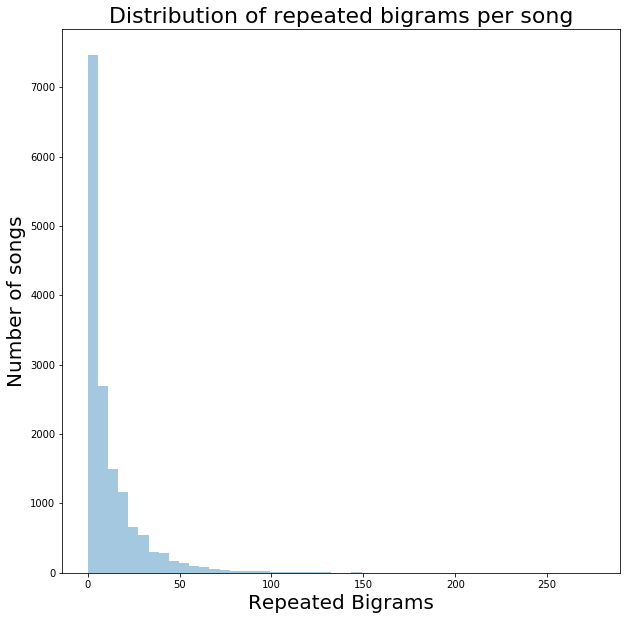

In [29]:
plt.figure(figsize = (10,10))
sns.distplot(df['repeated_bigrams'], kde = False)
plt.title("Distribution of repeated bigrams per song", fontsize = 22)
plt.xlabel("Repeated Bigrams", fontsize = 20)
plt.ylabel("Number of songs", fontsize = 20)
plt.savefig("../assets/visualizations/repeated_bigrams_distribution.png")

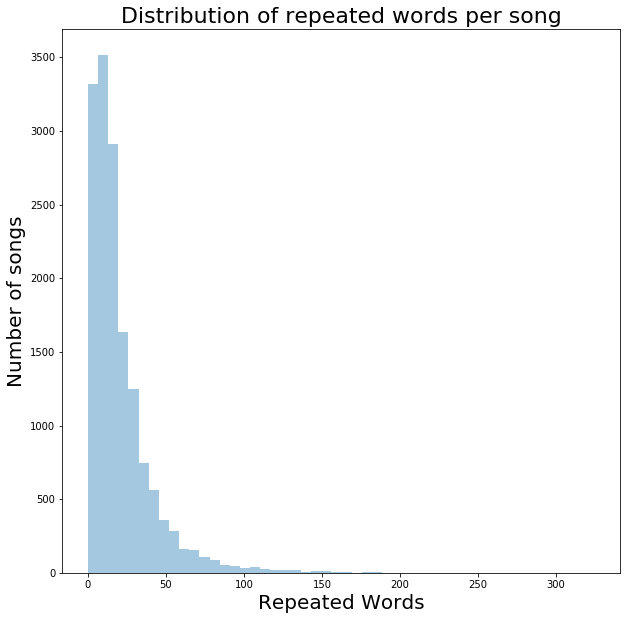

In [30]:
plt.figure(figsize = (10,10))
sns.distplot(df['repeated_exact_words'], kde = False)
plt.title("Distribution of repeated words per song", fontsize = 22)
plt.xlabel("Repeated Words", fontsize = 20)
plt.ylabel("Number of songs", fontsize = 20)
plt.savefig("../assets/visualizations/repeated_words_distribution.png")

In [31]:
def get_most_common_bigram(text):
    bigrams = make_bigrams(text)
    most = 0
    most_common_bigram = None
    for bigram in list(set(bigrams)):
        if (bigrams.count(bigram) - 1) > most:
            most = (bigrams.count(bigram) - 1)
            most_common_bigram = bigram
    if most > 1:
        return most_common_bigram
    else:
        return None

df['most_common_bigram'] = df['text'].map(get_most_common_bigram)

In [32]:
df['most_common_bigram'].head()

285    kurban olam
286           None
289           None
292           None
296       allah ey
Name: most_common_bigram, dtype: object

In [33]:
temp_df = pd.DataFrame(df['most_common_bigram'].value_counts())

temp_df.head(20)

,most_common_bigram
aman aman,75
bir gün,52
oy oy,37
vay vay,35
yar yar,33
gel gel,31
bu gece,27
beni beni,18
bir daha,16
ne olur,15


In [34]:
def get_most_common_non_repeated_bigram(text):
    bigrams = make_bigrams(text)
    most = 0
    most_common_bigram = None
    for bigram in list(set(bigrams)):
        if (bigram.split()[0] != bigram.split()[1]) and ((bigrams.count(bigram) - 1) > most):
            most = (bigrams.count(bigram) - 1)
            most_common_bigram = bigram
    if most > 1:
        return most_common_bigram
    else:
        return None

df['most_common_non_repeated_bigram'] = df['text'].map(get_most_common_non_repeated_bigram)
temp_df = pd.DataFrame(df['most_common_non_repeated_bigram'].value_counts())
temp_df.head()

,most_common_non_repeated_bigram
bir gün,52
bu gece,29
ne olur,17
bir daha,16
bu akşam,14


In [35]:
pre = df[df['written_after_2016'] == 0]
post = df[df['written_after_2016'] == 1]

In [36]:
pd.DataFrame(pre['most_common_non_repeated_bigram'].value_counts()).head()

,most_common_non_repeated_bigram
bir gün,52
bu gece,28
ne olur,17
bir daha,16
bu akşam,14


In [37]:
pd.DataFrame(post['most_common_non_repeated_bigram'].value_counts()).head()

,most_common_non_repeated_bigram
her gün,2
güldür gül,2
ya dost,1
affetmem seni,1
dünya ne,1


## Lemmatized versions of these features
- number of repeated lemmas
- number of repeated lemma bigrams
- most common lemma bigram
- most common non-repeated lemma bigram

In [38]:
df['lemmatized_text'] = df['text'].map(lemmatize)

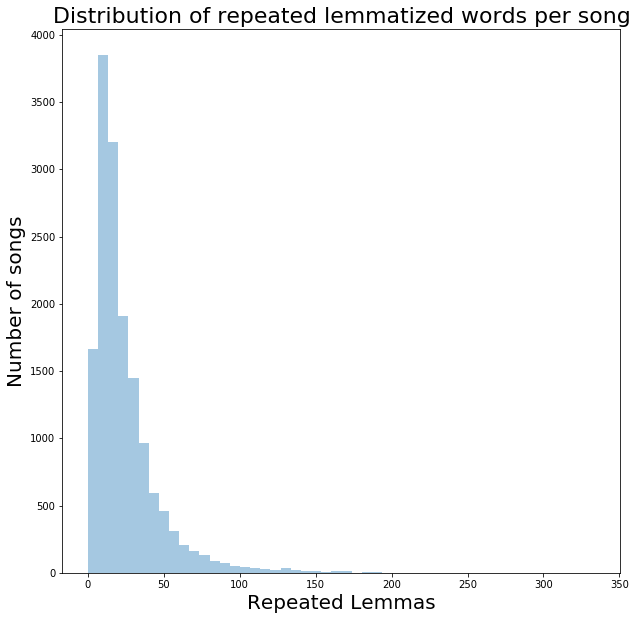

In [39]:
df['repeated_lemmatized_words'] = df['lemmatized_text'].map(count_repeated_words)
plt.figure(figsize = (10,10))
sns.distplot(df['repeated_lemmatized_words'], kde = False)
plt.title("Distribution of repeated lemmatized words per song", fontsize = 22)
plt.xlabel("Repeated Lemmas", fontsize = 20)
plt.ylabel("Number of songs", fontsize = 20)
plt.savefig("../assets/visualizations/repeated_lemmas_distribution.png")


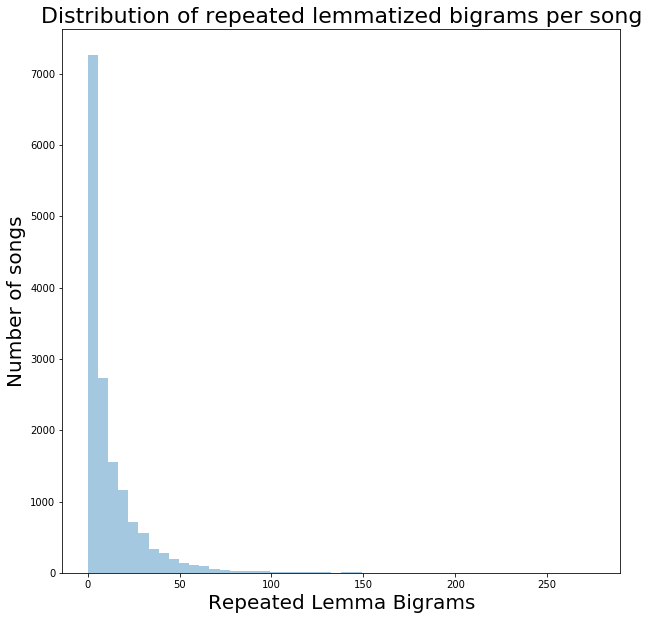

In [40]:
df['repeated_lemma_bigrams'] = df['lemmatized_text'].map(count_repeated_bigrams)
plt.figure(figsize = (10,10))
sns.distplot(df['repeated_lemma_bigrams'], kde = False)
plt.title("Distribution of repeated lemmatized bigrams per song", fontsize = 22)
plt.xlabel("Repeated Lemma Bigrams", fontsize = 20)
plt.ylabel("Number of songs", fontsize = 20)
plt.savefig("../assets/visualizations/repeated_lemma_bigrams_distribution.png")

In [41]:
df['most_common_lemma_bigram'] = df['lemmatized_text'].map(get_most_common_bigram)
temp_df = pd.DataFrame(df['most_common_lemma_bigram'].value_counts())
temp_df.head(5)

,most_common_lemma_bigram
aman aman,74
ne ol,62
sen ben,56
bir gün,55
gel gel,39


In [42]:
df['most_common_non_repeated_lemma_bigram'] = df['lemmatized_text'].map(get_most_common_non_repeated_bigram)
temp_df = pd.DataFrame(df['most_common_non_repeated_lemma_bigram'].value_counts())
temp_df.head(5)

,most_common_non_repeated_lemma_bigram
ne ol,64
sen ben,59
bir gün,55
bu gece,33
bir yan,31


In [43]:
df.columns

Index(['artist', 'album', 'text', 'release', 'name', 'year',
       'written_before_2002', 'written_before_2004', 'written_before_2006',
       'written_before_2008', 'written_after_2016', 'oy_length', 'ah_length',
       'ey_length', 'vay_length', 'oh_length', 'longest_word_length',
       'total_words', 'repeated_exact_words', 'repeated_bigrams',
       'most_common_bigram', 'most_common_non_repeated_bigram',
       'lemmatized_text', 'repeated_lemmatized_words',
       'repeated_lemma_bigrams', 'most_common_lemma_bigram',
       'most_common_non_repeated_lemma_bigram'],
      dtype='object')

### About this dataframe:
- numeric features:
 - longest_oy, longest_ah, longest_ey, longest_vay, longest_oh, 
 - longest_word_length, total_words
 - repeated_exact_words, repeated_bigrams
 - repeated_lemmatized_words, repeated_lemma_bigrams
- categorical features
 - most_common_bigram, most_common_non_repeated_bigram
 - most_common_lemma_bigram, most_common_non_repeated_lemma_bigram

In [44]:
df.fillna('na', inplace=True)

In [45]:
df.to_csv("../assets/data/full_frame_20180716.csv")

## Word Clouds

In [46]:
from wordcloud import WordCloud

from PIL import Image

In [47]:
stops = STOP_WORDS

In order to not show common words, I'm taking them out. They aren't considered stop words because they're important, but they would make for a bad word cloud.

In [48]:
stops.add("ben")
stops.add("bir")
stops.add("sen")
stops.add("ol")
stops.add("gel")

In [109]:
mask = np.array(Image.open("../assets/visualizations/maskturk.jpg"))

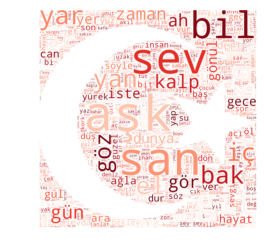

In [110]:
wc = WordCloud(background_color="white", max_words=10000, stopwords=stops, width = 10000, height = 8000, mask = mask, colormap='Reds')

text = df['lemmatized_text']

text = list(text)

text  = " ".join(text)

wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.imshow(cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.savefig("../assets/visualizations/wordcloud1.png")

In [51]:
df.columns

Index(['artist', 'album', 'text', 'release', 'name', 'year',
       'written_before_2002', 'written_before_2004', 'written_before_2006',
       'written_before_2008', 'written_after_2016', 'oy_length', 'ah_length',
       'ey_length', 'vay_length', 'oh_length', 'longest_word_length',
       'total_words', 'repeated_exact_words', 'repeated_bigrams',
       'most_common_bigram', 'most_common_non_repeated_bigram',
       'lemmatized_text', 'repeated_lemmatized_words',
       'repeated_lemma_bigrams', 'most_common_lemma_bigram',
       'most_common_non_repeated_lemma_bigram'],
      dtype='object')

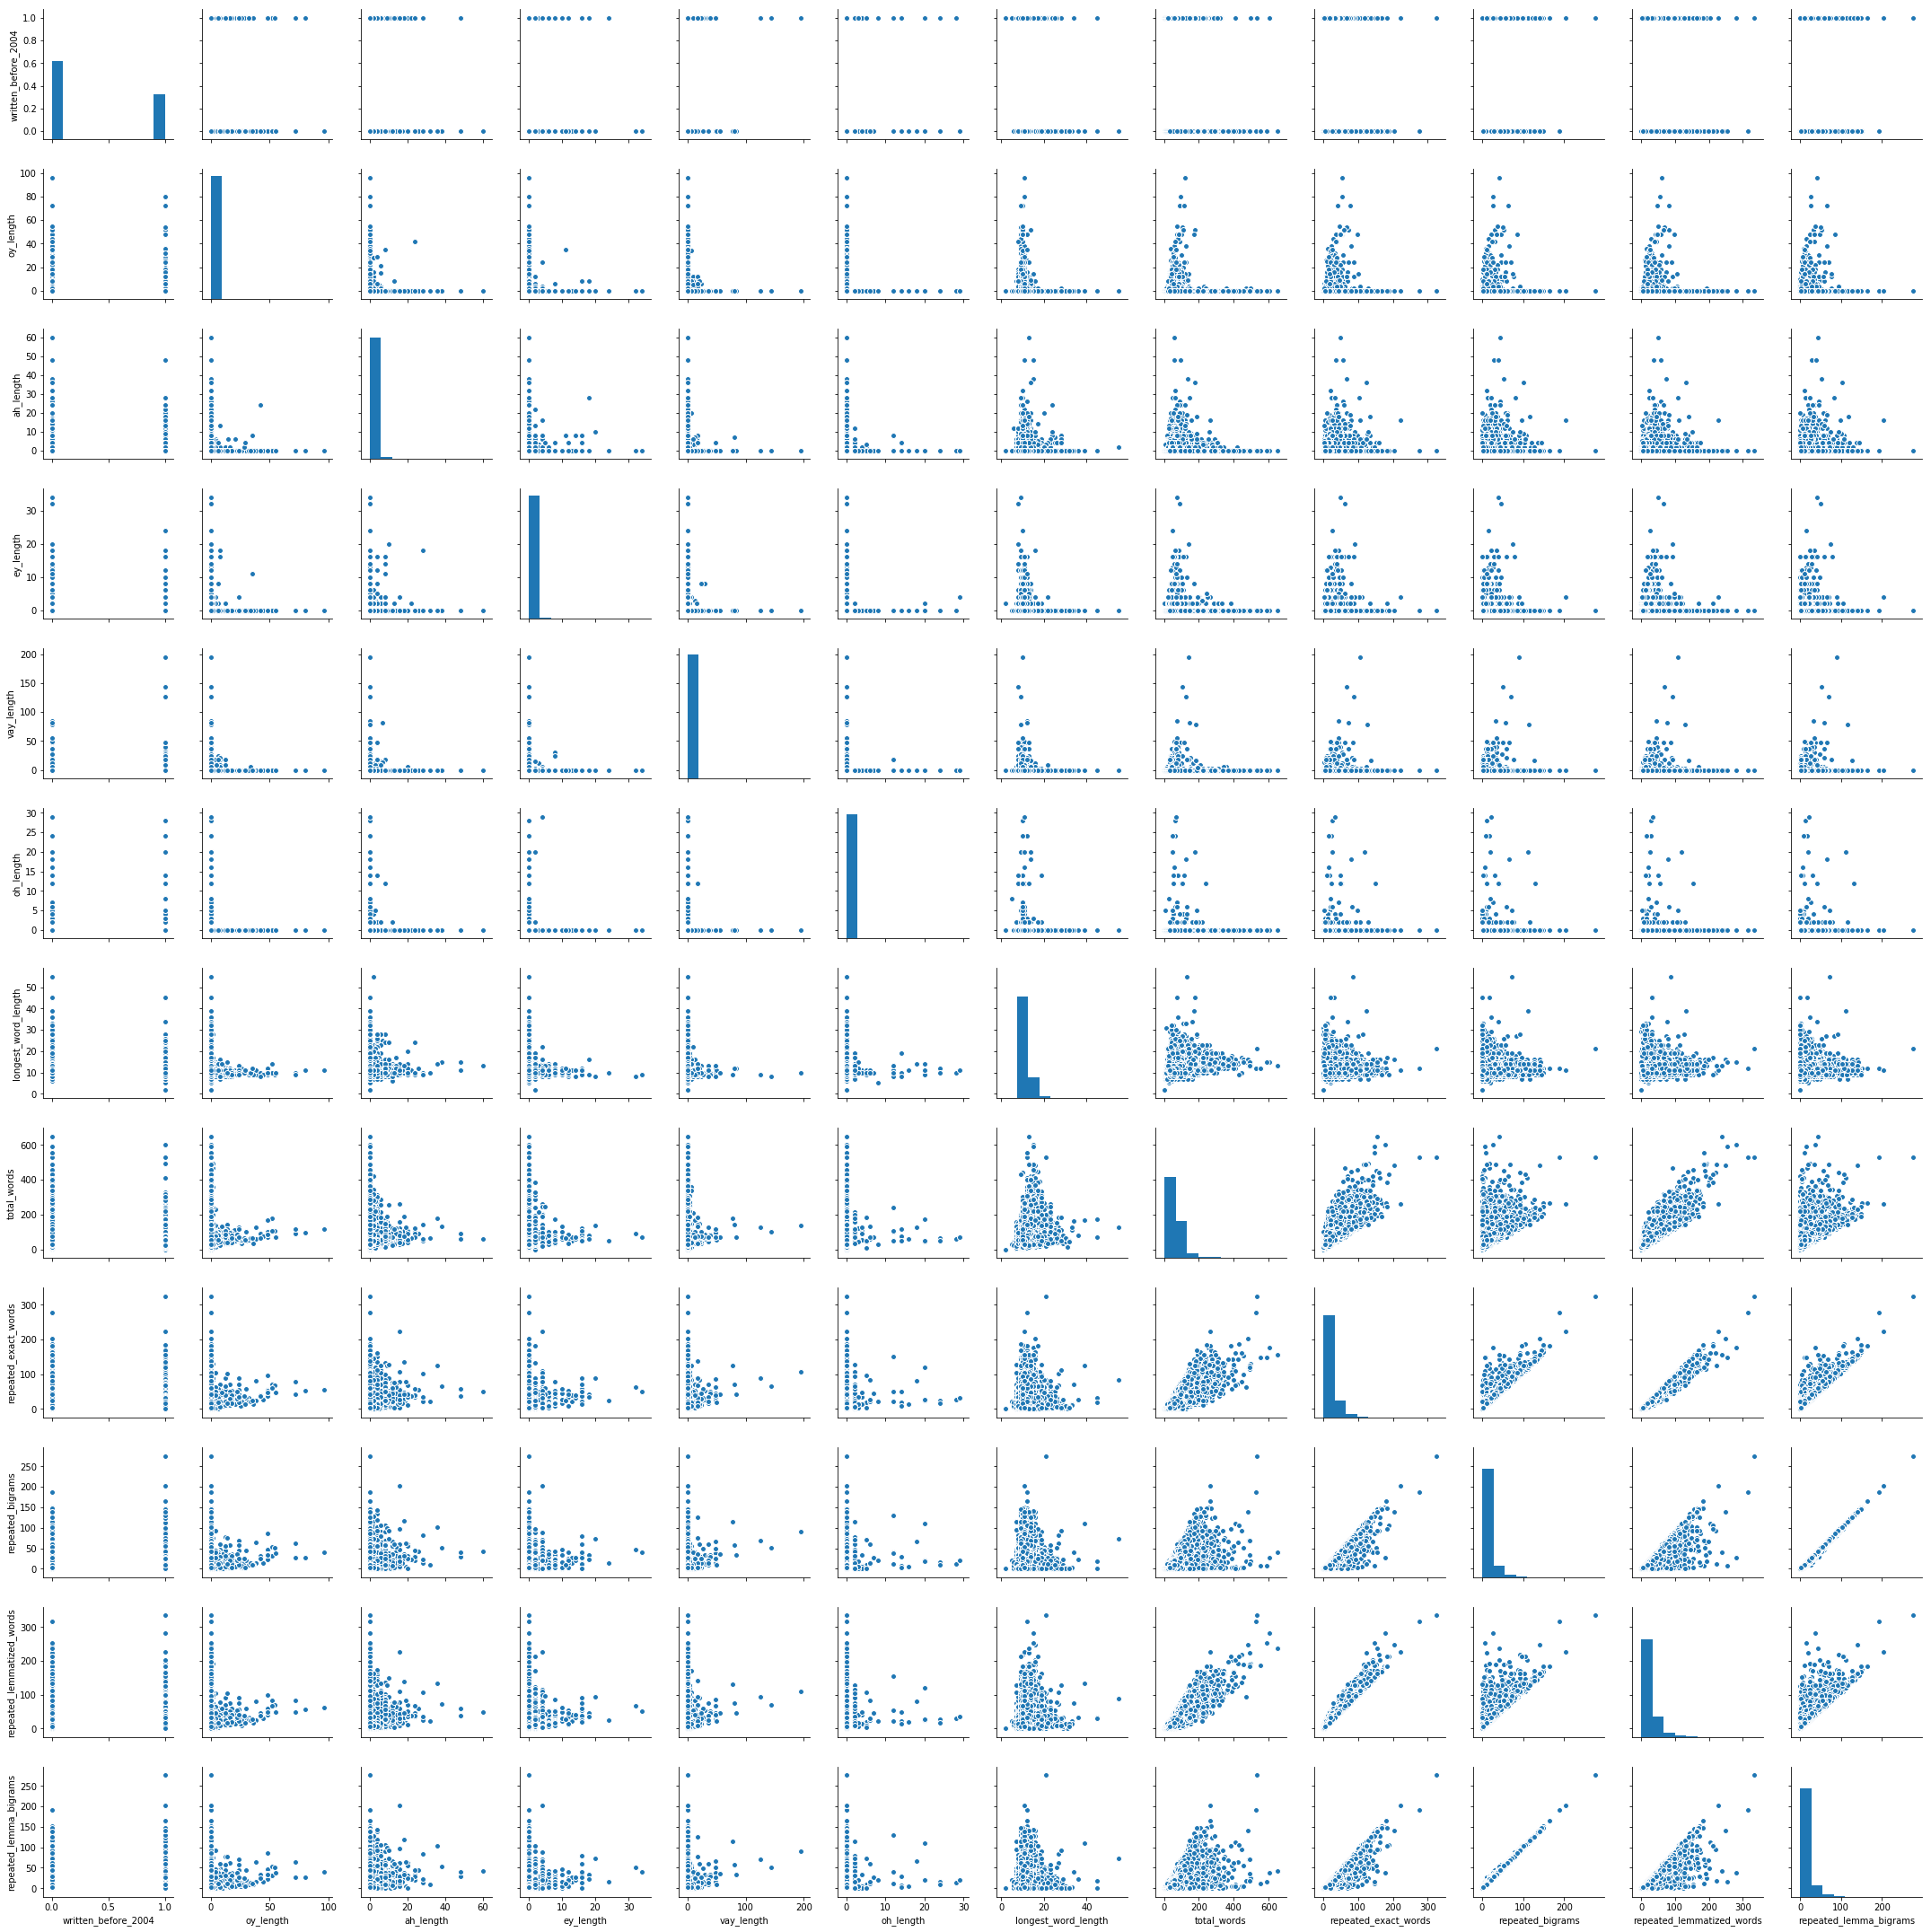

In [52]:
sns.pairplot(df[['written_before_2004','oy_length', 'ah_length', 'ey_length','vay_length', 'oh_length', 'longest_word_length', 'total_words','repeated_exact_words', 'repeated_bigrams', 'repeated_lemmatized_words', 'repeated_lemma_bigrams']])

In [53]:
df[['written_before_2004', 'oy_length']].groupby('written_before_2004').mean()

,oy_length
written_before_2004,
0,0.221094
1,0.304718


In [54]:
df[['written_before_2004', 'oy_length']].groupby('written_before_2004').std()

,oy_length
written_before_2004,
0,2.319418
1,2.861615


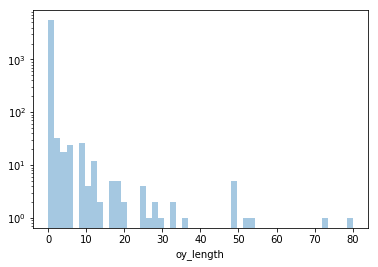

In [55]:
sns.distplot(df[df['written_before_2004']==1]['oy_length'], kde = False, hist_kws = {'log':True})

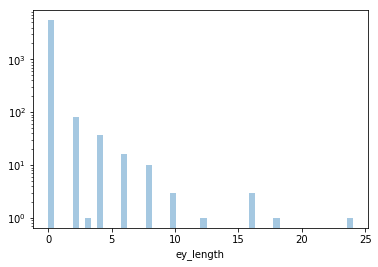

In [56]:
sns.distplot(df[df['written_before_2004']==1]['ey_length'], kde = False, hist_kws = {'log':True})

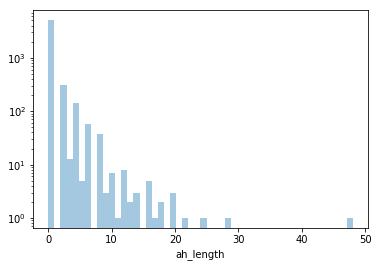

In [57]:
sns.distplot(df[df['written_before_2004']==1]['ah_length'], kde = False, hist_kws = {'log':True})

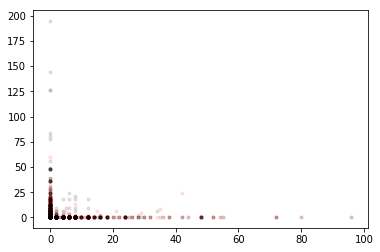

In [58]:
plt.scatter(df['oy_length'], df['ah_length'], alpha = 0.1, marker = '.', color = 'r')
plt.scatter(df['oy_length'], df['vay_length'], alpha = 0.1, marker = '.', color = 'k')

In [59]:
pre = df[df['written_before_2004']==1]
post = df[df['written_before_2004']==0]

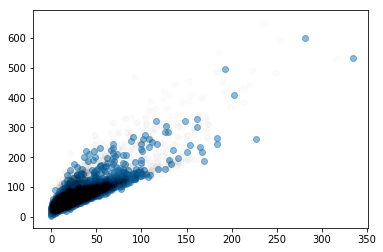

In [60]:
plt.scatter(pre['repeated_lemmatized_words'], pre['total_words'], alpha = 0.5)
plt.scatter(post['repeated_lemmatized_words'], post['total_words'], alpha = 0.01, color = 'k')

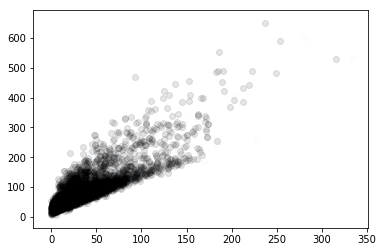

In [61]:
plt.scatter(pre['repeated_lemmatized_words'], pre['total_words'], alpha = 0.01)
plt.scatter(post['repeated_lemmatized_words'], post['total_words'], alpha = 0.1, color = 'k')

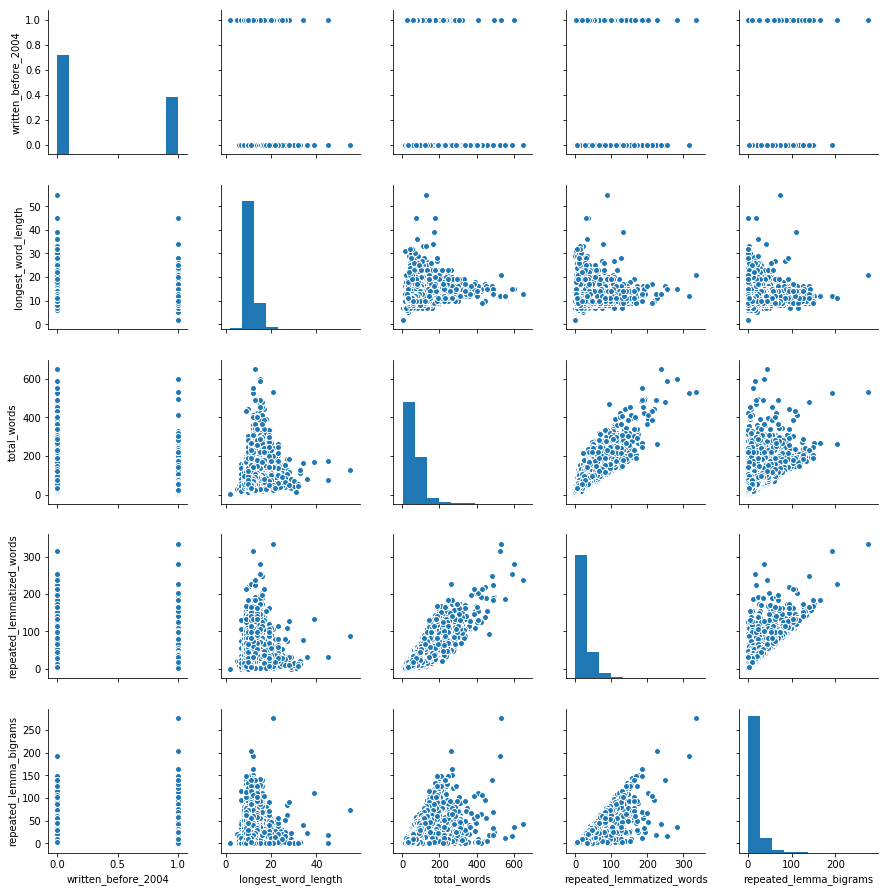

In [62]:
sns.pairplot(df[['written_before_2004', 'longest_word_length', 'total_words', 'repeated_lemmatized_words', 'repeated_lemma_bigrams']])

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not use

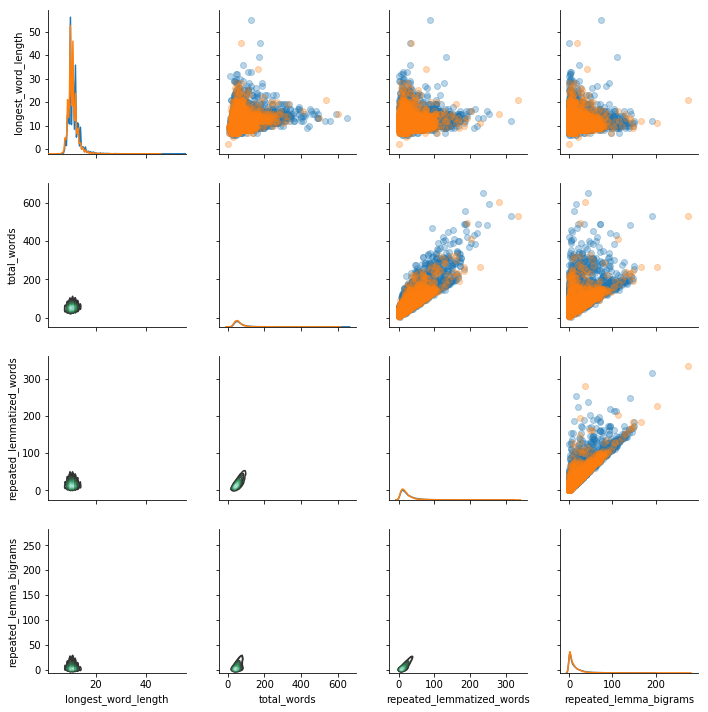

In [63]:
g = sns.PairGrid(df, vars=['longest_word_length', 'total_words', 'repeated_lemmatized_words', 'repeated_lemma_bigrams'], hue='written_before_2004')
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, alpha = 0.3)

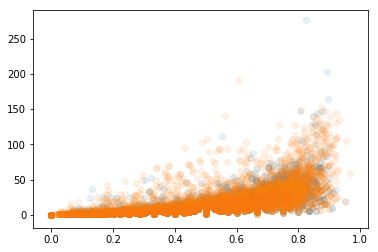

In [64]:
plt.scatter(pre['repeated_lemma_bigrams']/pre['repeated_lemmatized_words'], pre['repeated_lemma_bigrams'], alpha = 0.1)
plt.scatter(post['repeated_lemma_bigrams']/post['repeated_lemmatized_words'], post['repeated_lemma_bigrams'], alpha = 0.1)


In [65]:
mask = np.array(Image.open("../assets/visualizations/maskbaris.jpg"))

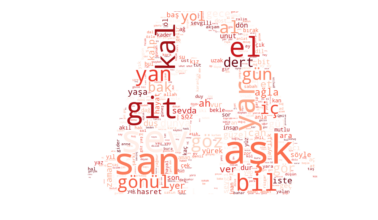

In [66]:
wc = WordCloud(background_color="white", max_words=10000, stopwords=stops, width = 10000, height = 8000, mask = mask, colormap='Reds')

text = pre['lemmatized_text']

text = list(text)

text  = " ".join(text)

wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.imshow(cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.savefig("../assets/visualizations/wordcloud_pre.png")

In [ ]:
mask = np.array(Image.open("../assets/visualizations/masksezen.jpg"))

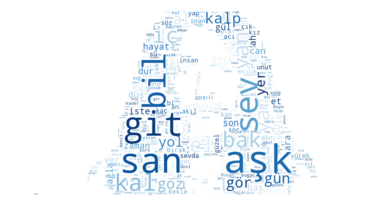

In [67]:
wc = WordCloud(background_color="white", max_words=10000, stopwords=stops, width = 10000, height = 8000, mask = mask, colormap='Blues')

text = post['lemmatized_text']

text = list(text)

text  = " ".join(text)

wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
# plt.imshow(cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.savefig("../assets/visualizations/wordcloud_post.png")

In [107]:
r = df['text'][np.random.choice(df.index)]
r

'gözlerine bakınca yüreğim kanatlanır ellerini tutunca sevgimiz alevlenir yıldızlar aynasısın kalbimin sarayında sen benim ruh eşimsin kanımsın damarımda ne kadar güzel sevip sevilmek bu yeryüzünde bir de korusak sevgimizi melekleriyle alem güzel hayat güzel sevenlerin gözlerinde bu sevgimiz destan olup gezsin dillerde sevdiğinin yanında bu dünya cennet olur dertleri unutturur bu hayat sonsuz olur yıldızlar aynasısın kalbimin sarayında sen benim ruh eşimsin kanımsın damarımda'

In [108]:
df[df['text']==r]

,artist,album,text,release,name,year,written_before_2002,written_before_2004,written_before_2006,written_before_2008,...,total_words,repeated_exact_words,repeated_bigrams,most_common_bigram,most_common_non_repeated_bigram,lemmatized_text,repeated_lemmatized_words,repeated_lemma_bigrams,most_common_lemma_bigram,most_common_non_repeated_lemma_bigram
37117,Mustafa Ceceli,Kalpten,gözlerine bakınca yüreğim kanatlanır ellerini ...,2014,Alem Güzel,2014,0,0,0,0,...,64,18,9,na,na,göz bak yürek kanat el tut sevgi alevlen yıldı...,24,10,na,na


In [70]:
from sklearn.feature_extraction.text import CountVectorizer

In [71]:
def make_vocab_list(corpus, stopwords = None, ngram_range = (1,1), min_df = 1):
    """Takes a corpus and returns a one column dataframe with words in the index and counts in a column.
    
    Options:
        - stopwords: either a list-like or None (default)
        - ngram_range: a tuple (default (1,1))
        - min_df: minimum document frequency (default 1)"""
    cv = CountVectorizer(stop_words=stopwords, ngram_range=ngram_range, min_df = min_df)
    cv.fit(corpus)
    transformed = cv.transform(corpus)
    
    return pd.DataFrame(pd.DataFrame(transformed.toarray(), columns=cv.get_feature_names()).sum().sort_values(ascending =False), columns = ['count'])


In [73]:
make_vocab_list(df['text']).head(20)

,count
bir,23351
bu,13221
ben,10836
ne,9709
sen,9043
beni,8974
seni,6941
bana,5773
de,5708
gibi,5649


In [74]:
make_vocab_list(df['lemmatized_text']).head(20)

,count
ben,33822
bir,23602
ol,21065
sen,19641
bu,15171
de,12428
ne,11952
gel,10653
sev,8355
git,8036


In [111]:
cvec = CountVectorizer()
cvec.fit(df['lemmatized_text'])

transformed_corpus = cvec.transform(df['lemmatized_text'])

word_table = pd.DataFrame(transformed_corpus.toarray(), columns=cvec.get_feature_names())

word_series = word_table.sum()

word_series = word_series.sort_values(ascending = False)

zipfs_test_df = pd.DataFrame({
    'word': word_series.index,
    'count': word_series.values
})

In [113]:
zipfs_test_df.shape

(45895, 2)

In [114]:
.2*45895

9179.0

In [118]:
zipfs_test_df.loc[:.2*45895,:]['count'].sum()

975654

In [119]:
zipfs_test_df['count'].sum()

1025069

In [123]:
975654/1025069

0.9517934890236657

Text(0.5,1,"Zipf's law for Turkish song corpus (lemmas) \n")

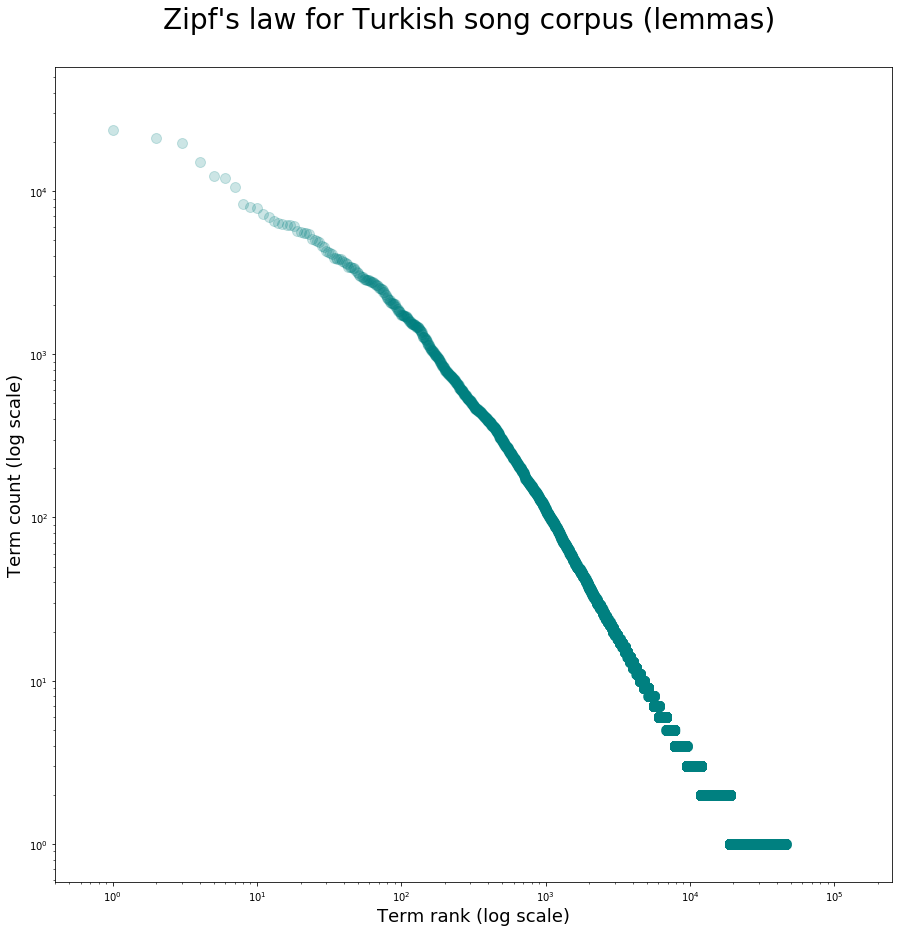

In [124]:
plt.figure(figsize=(15,15))
plt.yscale('log')
plt.xscale('log')
plt.scatter(zipfs_test_df.index, zipfs_test_df['count'], s = 100, marker = 'o', alpha = 0.2, c = "teal")
plt.xlim((10**-.4,10**5.4))
plt.xlabel("Term rank (log scale)", fontsize = 18)
plt.ylabel("Term count (log scale)", fontsize = 18)
plt.title("Zipf's law for Turkish song corpus (lemmas) \n", fontsize = 28)
